<a href="https://colab.research.google.com/github/MatveyOreshkinn/Minor/blob/main/Oreshkin's_best_hypotheses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

from google.colab import drive
import warnings


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
log_pattern = r'(\S+) - - \[(.*?)\] "(\S+) (\S+) (\S+\s\S+)" (\d+) (\d+) (\S+)'
parsed_data = []

with open('/content/drive/MyDrive/access.log', 'r') as file:
    for line in file:
        # Ищем совпадения с нашим шаблоном в каждой строке
        match = re.match(log_pattern, line)
        if match:
            # Если строка соответствует шаблону, извлекаем группы
            parsed_data.append(match.groups())

column_names = ['user_id', 'timestamp', 'http_method', 'request_url', 'http_version', 'status_code', 'response_size', 'session_id']


df = pd.DataFrame(parsed_data, columns=column_names)
df.head()

,user_id,timestamp,http_method,request_url,http_version,status_code,response_size,session_id
0,179.203.10.126,1/Jan/2015:00:00:02 +03:00,POST,/catalog.phtml,HTTP 1.1,200,4407,ID4887
1,179.203.10.126,1/Jan/2015:00:00:13 +03:00,POST,/search.phtml,HTTP 1.1,200,4025,ID4887
2,179.203.10.126,1/Jan/2015:00:00:15 +03:00,POST,/search.phtml,HTTP 1.1,200,3482,ID4887
3,179.203.10.126,1/Jan/2015:00:00:24 +03:00,POST,/catalog.phtml,HTTP 1.1,200,4904,ID4887
4,179.203.10.126,1/Jan/2015:00:00:30 +03:00,POST,/search.phtml,HTTP 1.1,200,2104,ID4887


In [32]:
df.describe()

,user_id,timestamp,http_method,request_url,http_version,status_code,response_size,session_id
count,239202,239202,239202,239202,239202,239202,239202,239202
unique,50850,239202,2,102,1,1,3000,50850
top,143.167.87.213,31/Jan/2015:23:59:57 +03:00,POST,/catalog.phtml,HTTP 1.1,200,4026,ID22347
freq,39,1,219864,110410,239202,239202,112,39


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239202 entries, 0 to 239201
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        239202 non-null  object
 1   timestamp      239202 non-null  object
 2   http_method    239202 non-null  object
 3   request_url    239202 non-null  object
 4   http_version   239202 non-null  object
 5   status_code    239202 non-null  object
 6   response_size  239202 non-null  object
 7   session_id     239202 non-null  object
dtypes: object(8)
memory usage: 14.6+ MB


In [34]:
df['http_version'].value_counts()  # все версия протокола одинаковые

,count
http_version,
HTTP 1.1,239202


In [35]:
df['status_code'].value_counts()  # все ответы серверы были успешными

,count
status_code,
200,239202


In [36]:
df.drop(['http_version', 'status_code'], inplace=True, axis=1)

df.head()

,user_id,timestamp,http_method,request_url,response_size,session_id
0,179.203.10.126,1/Jan/2015:00:00:02 +03:00,POST,/catalog.phtml,4407,ID4887
1,179.203.10.126,1/Jan/2015:00:00:13 +03:00,POST,/search.phtml,4025,ID4887
2,179.203.10.126,1/Jan/2015:00:00:15 +03:00,POST,/search.phtml,3482,ID4887
3,179.203.10.126,1/Jan/2015:00:00:24 +03:00,POST,/catalog.phtml,4904,ID4887
4,179.203.10.126,1/Jan/2015:00:00:30 +03:00,POST,/search.phtml,2104,ID4887


In [37]:
df['http_method'].value_counts()

,count
http_method,
POST,219864
GET,19338


In [38]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')

# Создаем DataFrame на уровне сессий
sessions_df = df.groupby('user_id').agg(
    session_start=('timestamp', 'min'),   # Время начала сессии
    session_end=('timestamp', 'max'),     # Время окончания сессии
    total_traffic=('response_size', 'sum'), # СУММАРНЫЙ трафик за сессию
    request_count=('request_url', 'count') # Количество запросов в сессии
).reset_index()


sessions_df['session_duration'] = (sessions_df['session_end'] - sessions_df['session_start']).dt.total_seconds()

# Определяем, была ли конверсия в сессии
conversion_sessions = df[df['request_url'].str.contains('order|thankyou|confirm', case=False, na=False)]['user_id'].unique()


sessions_df['is_conversion'] = sessions_df['user_id'].isin(conversion_sessions)
sessions_df['session_weekday'] = sessions_df['session_start'].dt.day_name()

sessions_df.head()

,user_id,session_start,session_end,total_traffic,request_count,session_duration,is_conversion,session_weekday
0,0.0.172.89,2015-01-04 23:39:04+03:00,2015-01-04 23:39:06+03:00,36983069,2,2.0,False,Sunday
1,0.1.12.77,2015-01-08 12:09:09+03:00,2015-01-08 12:10:02+03:00,2905412927272978,4,53.0,False,Thursday
2,0.1.123.163,2015-01-11 02:14:47+03:00,2015-01-11 02:15:00+03:00,48474036,2,13.0,False,Sunday
3,0.10.100.21,2015-01-07 04:17:31+03:00,2015-01-07 04:21:48+03:00,322737533554481435563327,6,257.0,False,Wednesday
4,0.101.22.59,2015-01-30 20:49:59+03:00,2015-01-30 21:06:37+03:00,361829503388397629323926,6,998.0,False,Friday


In [53]:
def safe_convert_to_numeric(series):
    """Безопасное преобразование колонки в числовой формат"""
    try:
        return pd.to_numeric(series, errors='coerce')
    except:

        return series.astype(float)


sessions_df['total_traffic'] = safe_convert_to_numeric(sessions_df['total_traffic'])
sessions_df['session_duration'] = safe_convert_to_numeric(sessions_df['session_duration'])

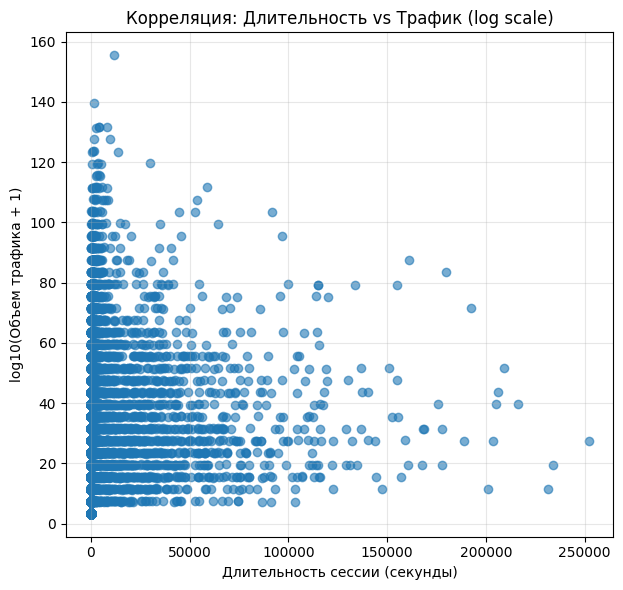

In [54]:


sessions_df_clean = sessions_df.dropna(subset=['total_traffic', 'session_duration'])

# Преобразуем total_traffic в более читаемый формат
sessions_df_clean['total_traffic_mb'] = sessions_df_clean['total_traffic'] / (1024 * 1024)  # в мегабайты
sessions_df_clean['total_traffic_gb'] = sessions_df_clean['total_traffic'] / (1024 * 1024 * 1024)  # в гигабайты


plt.figure(figsize=(12, 6))



plt.subplot(1, 2, 2)
plt.scatter(sessions_df_clean['session_duration'], np.log10(sessions_df_clean['total_traffic'] + 1), alpha=0.6)
plt.xlabel('Длительность сессии (секунды)')
plt.ylabel('log10(Объем трафика + 1)')
plt.title('Корреляция: Длительность vs Трафик (log scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [57]:
# 2. Расчет коэффициента корреляции Пирсона
try:
    correlation, p_value = stats.pearsonr(sessions_df_clean['session_duration'], sessions_df_clean['total_traffic'])

    print("Результаты анализа корреляции:")
    print(f"Коэффициент корреляции Пирсона: {correlation:.4f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Количество наблюдений в анализе: {len(sessions_df_clean)}")

    # 3. Интерпретация результатов
    print("\nИнтерпретация:")
    if p_value < 0.05:
        if correlation > 0.7:
            print("Сильная положительная корреляция (гипотеза подтверждается)")
        elif correlation > 0.3:
            print("Умеренная положительная корреляция (гипотеза частично подтверждается)")
        elif correlation > 0:
            print("Слабая положительная корреляция (гипотеза слабо подтверждается)")
        elif correlation < 0:
            print("Отрицательная корреляция (гипотеза опровергается)")
        else:
            print("➖ Нулевая корреляция")
    else:
        print(" Корреляция статистически не значима (p-value > 0.05)")

except ValueError as e:
    print(f"Ошибка при расчете корреляции: {e}")
    print("Возможно, недостаточно данных для анализа")

Результаты анализа корреляции:
Коэффициент корреляции Пирсона: 0.0055
P-value: 0.217971
Количество наблюдений в анализе: 50850

Интерпретация:
 Корреляция статистически не значима (p-value > 0.05)


Средняя длительность сессии по дням недели:
  session_weekday  session_duration
1          Monday       1488.695047
5         Tuesday       1238.862069
6       Wednesday        877.108849
4        Thursday       1062.296342
0          Friday       1590.635054
2        Saturday       1474.454021
3          Sunday       1515.887496


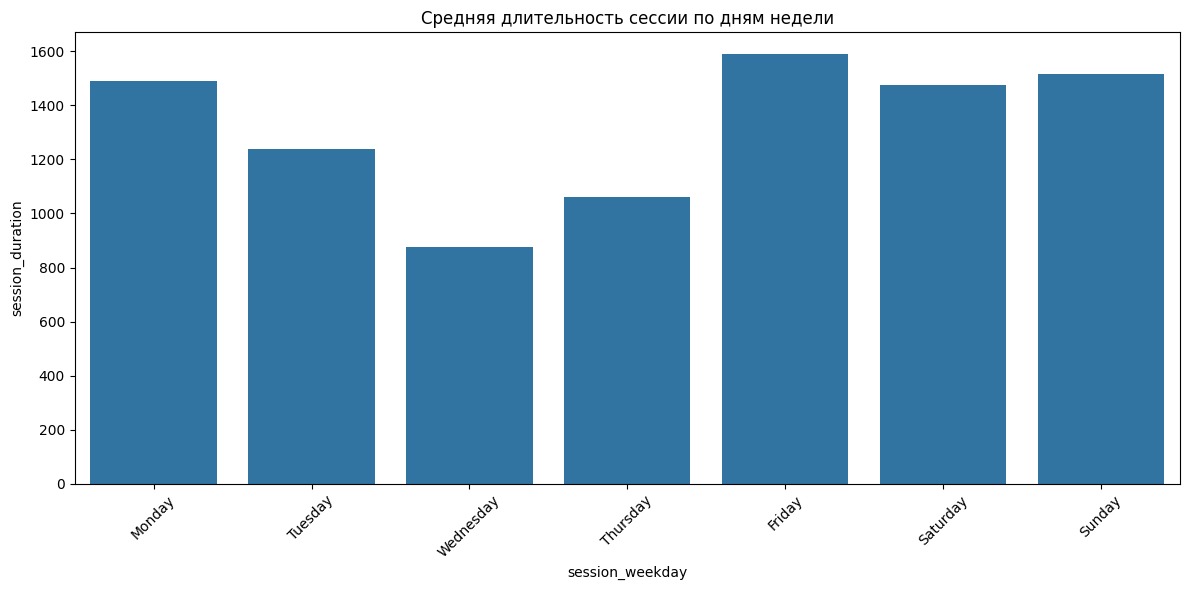


Сравнение средней длительности: будни = 1251.52, выходные = 1495.17
Результат t-теста: p-value = 0.0064
Гипотеза подтверждается: длительность сессий на выходных значимо отличается.


In [56]:
weekday_duration = sessions_df.groupby('session_weekday')['session_duration'].mean().reset_index()

# Упорядочим дни недели правильно
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_duration['session_weekday'] = pd.Categorical(weekday_duration['session_weekday'], categories=days_order, ordered=True)
weekday_duration = weekday_duration.sort_values('session_weekday')

print("Средняя длительность сессии по дням недели:")
print(weekday_duration)


plt.figure(figsize=(12, 6))
sns.barplot(data=weekday_duration, x='session_weekday', y='session_duration')
plt.title('Средняя длительность сессии по дням недели')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сравним выходные (суббота, воскресенье) с буднями
weekday_duration['is_weekend'] = weekday_duration['session_weekday'].isin(['Saturday', 'Sunday'])
weekend_comparison = weekday_duration.groupby('is_weekend')['session_duration'].mean()
print(f"\nСравнение средней длительности: будни = {weekend_comparison[False]:.2f}, выходные = {weekend_comparison[True]:.2f}")

from scipy.stats import ttest_ind

weekend_sessions = sessions_df[sessions_df['session_weekday'].isin(['Saturday', 'Sunday'])]['session_duration']
weekday_sessions = sessions_df[~sessions_df['session_weekday'].isin(['Saturday', 'Sunday'])]['session_duration']

stat, p_value = ttest_ind(weekend_sessions, weekday_sessions, equal_var=False)
print(f"Результат t-теста: p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Гипотеза подтверждается: длительность сессий на выходных значимо отличается.")
else:
    print("Гипотеза не подтверждается: значимой разницы в длительности сессий не обнаружено.")